# Direct inverse design: conditional variational autoencoder

## Import modules

In [1]:
import pickle
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import helper

# Dynamic GPU memory allocation: For local prototyping, don't block GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)


2023-07-03 13:46:54.865819: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-07-03 13:46:55.445082: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-03 13:46:56.454424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 13:46:56.472428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 13:46:56.472613: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NU

## load the training data

In [2]:
data_path = 'datasets/dataset1_random.h5'

# load data and scalers
x_train, x_test, y_train, y_test = helper.load_reflection_spectra_data(
    data_path)
scaler_mat, scaler_thick = pickle.load(
    open('{}_scalers.pkl'.format(os.path.splitext(data_path)[0]), 'rb'))


### cVAE resnet model

*Note*, instead of `MaxPooling`, we here use `strides=2` to reduce the output dimension of a convolution by a factor of 2. In the up-sampling case (see forward model), strides can also be used with transpose convolutions to increase the output dimension. However the latter often leads to artifacts in the upsampled outputs, therefore for a robust first try dedicated `UpSampling` layers are preferred. 

In the down-sampling case, strides usually don't induce artifacts and are computationally cheaper as well as are more flexible (they are trainable), in contrast to `MaxPooling`.

First we define a helpers to generate sequences of `N_block` residual blocks:

In [3]:
def resblock_sequence_down(x_in, N_filter, N_blocks):
    x = x_in
    for i in range(N_blocks):
        x = helper.residual_block(x, N_filter, kernel_size=3, strides=1, with_BN=True)
    # down: use strides=2 for downsampling (more flexible, since trainable).
    x = helper.residual_block(x, N_filter, kernel_size=3, strides=2)
    return x


def resblock_sequence_up(x_in, N_filter, N_blocks):
    x = x_in
    for i in range(N_blocks):
        x = helper.residual_block(x, N_filter, kernel_size=3, strides=1, with_BN=True)
    # up: use upsampling (more robust than transpose convolutions with stride 2)
    x = keras.layers.UpSampling1D()(x)
    return x


def resblock_sequence_id(x_in, N_filter, N_blocks):
    # identity block sequence: input shape = output shape
    x = x_in
    for i in range(N_blocks):
        x = helper.residual_block(x, N_filter, kernel_size=3, strides=1, with_BN=True)
    return x

## RNG sampling layer for regularization

The latent space of a VAE is regularized via random sampling from a normal distribution during training and ragularization of these distributions using a KL loss. The KL loss will be introduced below.
Here we define a sampling layer that generates randomly perturbed latent vectors:

In [4]:
class SamplingRNG(keras.layers.Layer):
    """layer to sample a normal distributed random numbers z with mean `z_mean` and logarithmic variance `z_log_var`"""

    def call(self, inputs):
        z_mean, z_var_log = inputs
        epsilon = keras.backend.random_normal(shape=tf.shape(z_mean)[1:])
        z = z_mean + keras.backend.exp(0.5 * z_var_log) * epsilon
        return z

## define the encoder

The cVAE consists of first an encoder. This compresses the condition (target spectrum) and the geometry (design) into a latent space.

In [5]:
keras.backend.clear_session()

# some config for the cVAE
latent_dim = 2   # for interpretability
N_blocks = 4     # Nr of resblocks between upsamplings


# input layers
condition_target_spec_input = keras.layers.Input(
    shape=y_train.shape[1:], name='condition_in')
design_in = keras.Input(shape=x_train.shape[1:], name='design_in')

# spectrum path
x = condition_target_spec_input
x = resblock_sequence_down(x, N_filter=32, N_blocks=N_blocks)   # 64 --> 32
x = resblock_sequence_down(x, N_filter=64, N_blocks=N_blocks)   # 32 --> 16
x = resblock_sequence_down(x, N_filter=128, N_blocks=N_blocks)  # 16 --> 8
x = resblock_sequence_down(x, N_filter=256, N_blocks=N_blocks)  # 8 --> 4
x_spec = keras.layers.Flatten()(x)

# geometry path
x = design_in
x = resblock_sequence_id(x, N_filter=128, N_blocks=N_blocks)    # 5 --> 2
x_design = keras.layers.Flatten()(x)

# merge both paths
x = keras.layers.Concatenate()([x_spec, x_design])
x = keras.layers.Dense(256)(x)
x = keras.layers.LeakyReLU(alpha=1e-1)(x)

# output: latent sampling
z_mean = keras.layers.Dense(latent_dim)(x)
z_var_log = keras.layers.Dense(latent_dim)(x)
z = SamplingRNG()([z_mean, z_var_log])


encoder = keras.Model([design_in, condition_target_spec_input], [
                      z_mean, z_var_log, z], name="encoder")
encoder.summary()


2023-07-03 13:46:57.166636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 13:46:57.168523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 13:46:57.236391: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 condition_in (InputLayer)      [(None, 64, 1)]      0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 64, 32)       32          ['condition_in[0][0]']           
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 32)      128         ['conv1d_1[0][0]']               
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 32)       0           ['batch_normalization[0][0]

## define the decoder

The second stage of the cVAE, and the actual inverse model after training, is the decoder.  It takes as input the condition (target spectrum) and a latent vector `z`. During training multiple design solutions for a given target spectrum will be mapped on different latent vectors `z` so that the latent space can be used to distinguish different solutions.

In [6]:
# condition_target_spec_input
latent_in = keras.Input(shape=(latent_dim,), name='latent_in')

# spectrum path
x = condition_target_spec_input
x = resblock_sequence_down(x, N_filter=32, N_blocks=N_blocks)   # 64 --> 32
x = resblock_sequence_down(x, N_filter=64, N_blocks=N_blocks)   # 32 --> 16
x = resblock_sequence_down(x, N_filter=128, N_blocks=N_blocks)  # 16 --> 8
x = resblock_sequence_down(x, N_filter=256, N_blocks=N_blocks)  # 8 --> 4
x_spec = keras.layers.Flatten()(x)

# merge with latent
x = keras.layers.Concatenate()([x_spec, latent_in])

# geometry generator path
x = keras.layers.Dense(5*128)(x)
x = keras.layers.Reshape((5, 128))(x)
x = resblock_sequence_id(x, N_filter=128, N_blocks=N_blocks)

# output: number of  channels from design
out_design = keras.layers.Conv1D(
    filters=x_train.shape[-1], kernel_size=1, name='design_out')(x)


decoder = keras.Model(
    [latent_in, condition_target_spec_input], 
    out_design, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 condition_in (InputLayer)      [(None, 64, 1)]      0           []                               
                                                                                                  
 conv1d_82 (Conv1D)             (None, 64, 32)       32          ['condition_in[0][0]']           
                                                                                                  
 batch_normalization_60 (BatchN  (None, 64, 32)      128         ['conv1d_82[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_73 (LeakyReLU)     (None, 64, 32)       0           ['batch_normalization_60[0]

## Define the full cVAE



In [7]:
z_mean_out, z_var_log_out, z_rnd_out = encoder([design_in, condition_target_spec_input])
design_pred = decoder([z_rnd_out, condition_target_spec_input])   # use randomized latent

cVAE = keras.Model([design_in, condition_target_spec_input], design_pred, name="cVAE")
cVAE.summary()

Model: "cVAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 design_in (InputLayer)         [(None, 5, 2)]       0           []                               
                                                                                                  
 condition_in (InputLayer)      [(None, 64, 1)]      0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          3032868     ['design_in[0][0]',              
                                 (None, 2),                       'condition_in[0][0]']           
                                 (None, 2)]                                                       
                                                                                               

## cVAE losses: reconstruction and KL

In order to regularize the latent space, we need to add a Kullback-Leibler divergence (KL) loss in addition to the MSE reconstruction loss. Adding custom loss functions in keras can be done via `model.add_loss`. We also add according metrics, those are only used for the status messages during training.
Finally we can compile and train the model with the optimizer (`AdamW`).


In [8]:
input_dim = np.product(x_train.shape[1:])
latent_dim = np.product(z.shape[1:])
beta = 0.001   # weight of KL loss. If too high, reconstruction will suffer.


# --- add multiple losses to the model
# reconstruction loss
reconstruction_loss = keras.losses.mse(
    keras.backend.flatten(design_in), 
    keras.backend.flatten(design_pred))
cVAE.add_loss(reconstruction_loss)
cVAE.add_metric(reconstruction_loss, name='reconstr_loss', aggregation='mean')

# KL loss
kl_loss = keras.backend.sum(
    1 + z_var_log_out - keras.backend.square(z_mean_out) - keras.backend.exp(z_var_log_out), axis=-1)
kl_loss = beta * keras.backend.mean(-0.5 / latent_dim * kl_loss)
cVAE.add_loss(kl_loss)
cVAE.add_metric(kl_loss, name='kl_loss', aggregation='mean')

## Train the cVAE end-to-end

In contrast to the 2-stage training of the Tandem, the cVAE is trained end-to-end in a single run. Note that we have now two inputs for the full cVAE model: designs and spectra, the model output are the reconstructed designs, which are compared to the input designs via MSE loss. 

After training, for inverse design we will use only the decoder part.

In [9]:
# compile the model
optimizer = keras.optimizers.AdamW(learning_rate=0.0002)
cVAE.compile(optimizer=optimizer)

## ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=5, verbose=1)

# fit the model with BN --> increasing batchsize schdedule
hist = None  # global history after BS incrase
for i in range(4):  # 4x50 epochs, doubling batchsize
    _h = cVAE.fit(x=[x_train, y_train], y=[x_train],
                  validation_split=.2,
                  batch_size=16 * 2**i, epochs=50,
                  callbacks = [reduce_lr])
    if hist is None:
        hist = _h
    else:
        for k in hist.history:
            hist.history[k] = np.concatenate([hist.history[k], _h.history[k]])

# plot loss
plt.figure()
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend()
plt.show()

Epoch 1/50


2023-07-03 13:47:32.093267: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-03 13:47:34.195549: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-03 13:47:34.240783: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f118a82c340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-03 13:47:34.240801: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-07-03 13:47:34.244037: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-03 13:47:34.364560: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

2375/2375 [==============================] - 321s 107ms/step - loss: 0.7728 - reconstr_loss: 0.7587 - kl_loss: 0.0141 - val_loss: 0.5913 - val_reconstr_loss: 0.5783 - val_kl_loss: 0.0130 - lr: 2.0000e-04
Epoch 2/50
2375/2375 [==============================] - 255s 107ms/step - loss: 0.5429 - reconstr_loss: 0.5324 - kl_loss: 0.0105 - val_loss: 0.4931 - val_reconstr_loss: 0.4829 - val_kl_loss: 0.0102 - lr: 2.0000e-04
Epoch 3/50
2375/2375 [==============================] - 255s 107ms/step - loss: 0.4637 - reconstr_loss: 0.4547 - kl_loss: 0.0090 - val_loss: 0.4388 - val_reconstr_loss: 0.4299 - val_kl_loss: 0.0089 - lr: 2.0000e-04
Epoch 4/50
2375/2375 [==============================] - 275s 116ms/step - loss: 0.4169 - reconstr_loss: 0.4087 - kl_loss: 0.0081 - val_loss: 0.3819 - val_reconstr_loss: 0.3737 - val_kl_loss: 0.0082 - lr: 2.0000e-04
Epoch 5/50
2375/2375 [==============================] - 272s 115ms/step - loss: 0.3834 - reconstr_loss: 0.3758 - kl_loss: 0.0076 - val_loss: 0.3844 - v

## save the cVAE sub-models

In [ ]:
cVAE.save('models/inversenet_cVAE_full.h5')
encoder.save('models/inversenet_cVAE_enc.h5')
decoder.save('models/inversenet_cVAE_dec.h5')

## Demo: reload a saved model

A previously saved model can be reloaded in keras as follows:

In [ ]:
decoder = keras.models.load_model('models/inversenet_cVAE_dec.h5')

2023-06-28 10:43:27.918892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-28 10:43:27.919121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-28 10:43:27.919240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Some simple benchmarking

pymoosh: calculating R for 500 samples...


500it [00:04, 107.45it/s]


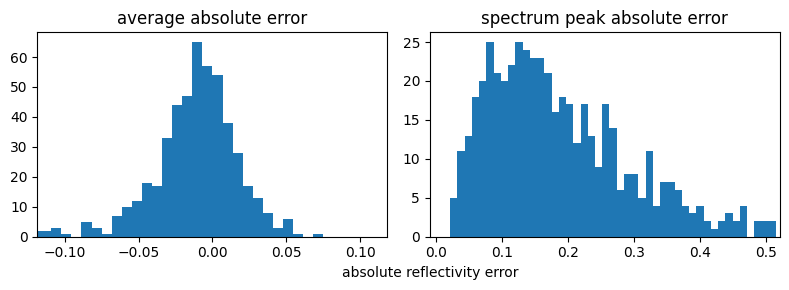

In [ ]:
# plot statistics
z_sample = np.random.normal(size=(500, 2))
#z_sample = np.zeros(shape=(500, 2))
y_sample = y_test[np.random.choice(len(y_test), len(z_sample), replace=False)]
decoder_in = [z_sample, y_sample]
designs_predict = decoder.predict(decoder_in, verbose=0)
y_resim = helper.calc_R_for_network_designs(designs_predict, scaler_mat, scaler_thick)

helper.plot_benchmark_R_stat(y_resim, y_sample)

pymoosh: calculating R for 9 samples...


9it [00:00, 106.89it/s]


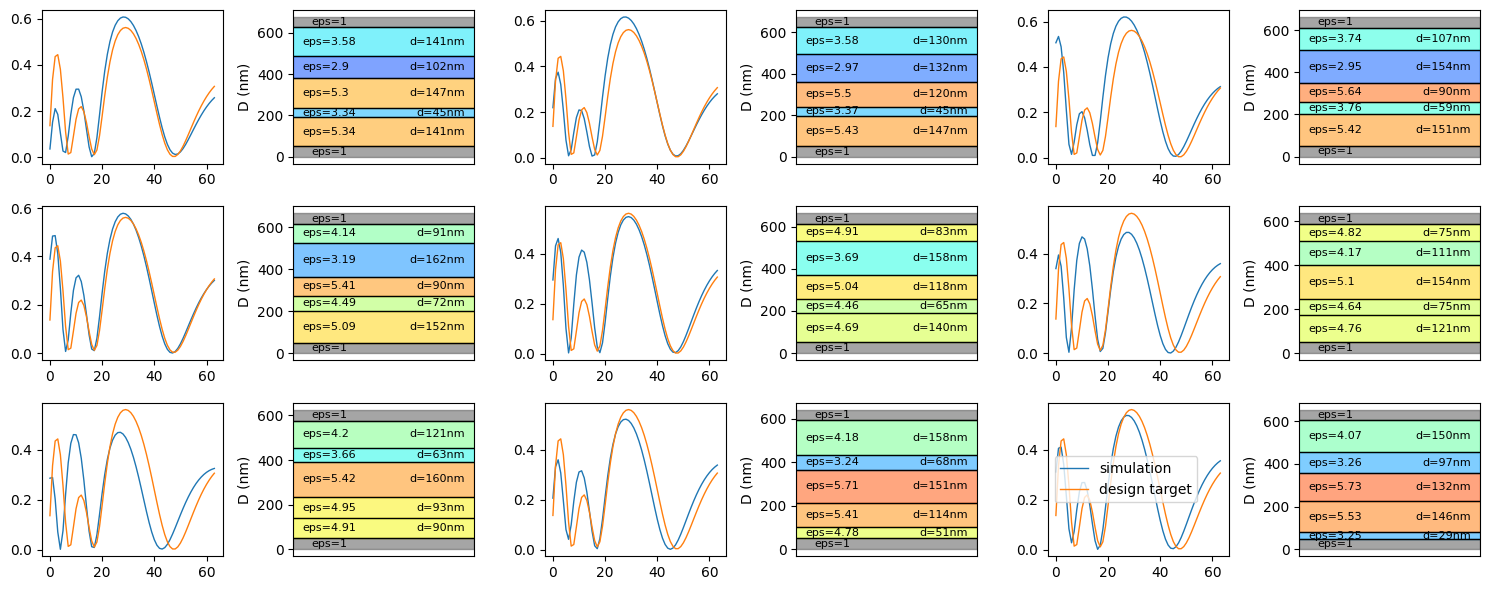

In [ ]:
# take a random, known, single spectrum as target
i_test = np.random.randint(len(y_test))

# evaluate 9 positions in latent space
z_sample = np.array([[i, i] for i in np.linspace(-1, 1, 9) ])

# predict and simulate via pymoosh
y_sample = y_test[len(z_sample)*[i_test]]
decoder_in = [z_sample, y_sample]
designs_predict = decoder.predict(decoder_in, verbose=0)
y_resim = helper.calc_R_for_network_designs(
    designs_predict, scaler_mat, scaler_thick)

# plot results
helper.plot_benchmark_R_samples(y_resim, y_sample, N_plot=(3, 3),
                                random_order=False, plot_design=True,
                                y_designs=designs_predict,
                                scaler_mat=scaler_mat, scaler_thick=scaler_thick,
                                labels=['simulation', 'design target'])
